<a href="https://colab.research.google.com/github/sohamtalukdar/Segmentation-of-Kidneys-in-MRI/blob/main/Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
#tf. test. gpu_device_name()
# !sudo apt-get update -y
# !sudo apt-get install python3.9
!python --version
#!nvidia-smi -q
tf.__version__

Python 3.7.13


'2.8.2'

In [ ]:
!pip install nibabel --upgrade
#!pip install keras-unet-collection==0.1.13
#!pip install keras-adabound
#!pip install focal-loss
#pip install segmentation_models_3D
#from keras_unet_collection import models
#from keras_adabound import AdaBound
import scipy.ndimage as ndi
import tensorflow as tf
from tensorflow import keras
from keras.layers import *
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import os
import nibabel as nib
from nibabel.processing import conform
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Activation, ReLU, BatchNormalization, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, Nadam,RMSprop
import random
from tqdm import tqdm 
from skimage.io import imread, imshow
from skimage.transform import resize
from PIL import Image
from keras import backend as K
from PIL import ImageOps

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
""" from Alex Daniel """

def rescale(data, black=None, white=None):
    if black is None:
        black = np.mean(data) - 0.5 * np.std(data)
        if black < data.min():
            black = data.min()
    if white is None:
        white = np.mean(data) + 4 * np.std(data)
        if white > data.max():
            white = data.max()
    data = np.clip(data, black, white) - black
    data = data / (white - black)
    return data

def normalise_image(image, affine):

    image = rescale(image)
    img = nib.Nifti1Image(image, affine)
    zoom = img.header.get_zooms()
    img = conform(img, out_shape=(240, 240, img.shape[-1]),
                  voxel_size=(1.458, 1.458, zoom[-1] * 0.998),
                  orientation='LIP')
    image = img.get_fdata()
    image = resize(image, (256, 256, image.shape[2]))
    zoom = img.header.get_zooms()
    return image
  
def normalise_mask(mask, affine):

    img = nib.Nifti1Image(mask, affine)
    img = conform(img, out_shape=(240, 240, img.shape[-1]),
                  voxel_size=(1.458, 1.458, img.header.get_zooms()[-1] *
                              0.998),
                  orientation='LIP')
    mask = img.get_fdata()
    mask = resize(mask, (256, 256, mask.shape[2]))
    mask = np.round(mask)
    return mask

In [ ]:
ground_truths = []
base_scans = []
dir = '/content/drive/MyDrive/ColabNotebooks/UNet/'
for f in sorted(os.listdir(dir + 'GroundTruth/')):
  image = nib.load(dir + 'GroundTruth/' + f)
  ground_truths.append(image)
for f in sorted(os.listdir(dir + 'Masks_T1/')):
  image = nib.load(dir + 'Masks_T1/'+ f)
  base_scans.append(image)
print(ground_truths[1].header.get_data_shape())


(256, 256, 17)


In [ ]:
gt_arrays = []
gt_affine = []
base_arrays = []
base_affine = []
for img in ground_truths:
  affine = img.affine
  gt_voxels = img.get_fdata()
  normalised = normalise_mask(gt_voxels, affine)
  gt_arrays.append(normalised)
for img in base_scans:
  affine = img.affine
  base_voxels = img.get_fdata()
  normalised = normalise_image(base_voxels, affine)
  base_arrays.append(base_voxels)
pairs = zip(gt_arrays, base_arrays)

print(gt_arrays[1].shape)
print(len(gt_arrays), len(gt_affine))
print(type(base_arrays[2]))




(256, 256, 17)
10 0
<class 'numpy.ndarray'>


In [ ]:
x_series = pd.Series(base_arrays)
y_series = pd.Series(gt_arrays)

'''
Courtesy of Alex Daniel
'''

def tf_arrays(series):
    data = np.concatenate(series, 2)
    data = np.swapaxes(data, 0, 2)
    data = np.swapaxes(data, 1, 2)
    data = np.expand_dims(data, 3)
    return data

x_data = tf_arrays(x_series)
y_data = tf_arrays(y_series)
"""
for img in base_arrays:
  for i in range(0,17):
    x_images.append(img[:,:,i,np.newaxis])
for img in gt_arrays:
  for i in range(0,17):
    y_images.append(img[:,:,i,np.newaxis])
"""

print(len(x_data), len(y_data))
print(x_data[1].shape, y_data[1].shape)


"""
fig, ax = plt.subplots(2)
ax[0].imshow(x_images[46])
ax[1].imshow(y_images[46])
plt.show()
"""

170 170
(256, 256, 1) (256, 256, 1)


'\nfig, ax = plt.subplots(2)\nax[0].imshow(x_images[46])\nax[1].imshow(y_images[46])\nplt.show()\n'

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(x_data, y_data, test_size = 0.1)

In [ ]:
### UNET

def convolution_operation(entered_input, filters=64):
    # Taking first input and implementing the first conv block
    conv1 = Conv2D(filters, kernel_size = (3,3), padding = "same")(entered_input)
    batch_norm1 = BatchNormalization()(conv1)
    act1 = ReLU()(batch_norm1)
    
    # Taking first input and implementing the second conv block
    conv2 = Conv2D(filters, kernel_size = (3,3), padding = "same")(act1)
    batch_norm2 = BatchNormalization()(conv2)
    act2 = ReLU()(batch_norm2)
    
    return act2



def encoder(entered_input, filters=64):
    # Collect the start and end of each sub-block for normal pass and skip connections
    enc1 = convolution_operation(entered_input, filters)
    MaxPool1 = MaxPooling2D(strides = (2,2))(enc1)
    return enc1, MaxPool1


def decoder(entered_input, skip, filters=64):
    # Upsampling and concatenating the essential features
    Upsample = Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(entered_input)
    Connect_Skip = Concatenate()([Upsample, skip])
    out = convolution_operation(Connect_Skip, filters)
    return out


def U_Net(Image_Size):
    # Take the image size and shape
    input1 = Input(Image_Size)
    
    # Construct the encoder blocks
    skip1, encoder_1 = encoder(input1, 64)
    skip2, encoder_2 = encoder(encoder_1, 64*2)
    skip3, encoder_3 = encoder(encoder_2, 64*4)
    skip4, encoder_4 = encoder(encoder_3, 64*8)
    
    # Preparing the next block
    conv_block = convolution_operation(encoder_4, 64*16)
    
    # Construct the decoder blocks
    decoder_1 = decoder(conv_block, skip4, 64*8)
    decoder_2 = decoder(decoder_1, skip3, 64*4)
    decoder_3 = decoder(decoder_2, skip2, 64*2)
    decoder_4 = decoder(decoder_3, skip1, 64)
    
    out = Conv2D(3, 1, padding="same", activation="softmax")(decoder_4)

    model = Model(input1, out)
    return model


In [ ]:
input_shape = (256, 256,1)
model = U_Net(input_shape)

In [ ]:
def dice_coefficient(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[0, 1])
    union = K.sum(y_true, axis=[0,1]) + K.sum(y_pred, axis=[0, 1])
    return K.mean((2. * intersection + smooth) / (union + smooth), axis=0)

def dice_loss(y_true, y_pred):
  return 1 - dice_coefficient(y_true, y_pred)


def jacard_coef(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    return (intersection + 1.0) / (K.sum(y_true) + K.sum(y_pred) - intersection + 1.0)

def precision(y_true, y_pred):
    return 

In [ ]:
model.compile(optimizer= Nadam(learning_rate = 1e-4), 
              loss= 'sparse_categorical_crossentropy',
              metrics = [jacard_coef,dice_coefficient,'accuracy']
              )

In [ ]:
history = model.fit(x=x_train, 
                   y=y_train, 
                   batch_size=2, 
                   steps_per_epoch=len(x_train)//2,
                   epochs=100, 
                   validation_data=(x_valid, y_valid), 
                   )

Epoch 1/100
76/76 [==============================] - 23s 103ms/step - loss: 0.4308 - jacard_coef: 0.0365 - dice_coefficient: 0.0749 - accuracy: 0.9465 - val_loss: 0.8314 - val_jacard_coef: 0.0368 - val_dice_coefficient: 0.0549 - val_accuracy: 0.9778
Epoch 2/100
76/76 [==============================] - 7s 95ms/step - loss: 0.1740 - jacard_coef: 0.0360 - dice_coefficient: 0.0958 - accuracy: 0.9832 - val_loss: 0.4580 - val_jacard_coef: 0.0368 - val_dice_coefficient: 0.0673 - val_accuracy: 0.9811
Epoch 3/100
76/76 [==============================] - 7s 95ms/step - loss: 0.1257 - jacard_coef: 0.0366 - dice_coefficient: 0.1086 - accuracy: 0.9857 - val_loss: 0.2353 - val_jacard_coef: 0.0368 - val_dice_coefficient: 0.0854 - val_accuracy: 0.9852
Epoch 4/100
76/76 [==============================] - 7s 95ms/step - loss: 0.1018 - jacard_coef: 0.0361 - dice_coefficient: 0.1127 - accuracy: 0.9880 - val_loss: 0.1398 - val_jacard_coef: 0.0368 - val_dice_coefficient: 0.1092 - val_accuracy: 0.9878
Epoch 

In [ ]:
model.evaluate(x_valid, y_valid)
predicted_masks = model.predict(x_valid)

1/1 [==============================] - 0s 180ms/step - loss: 0.0500 - jacard_coef: 0.0376 - dice_coefficient: 0.3834 - accuracy: 0.9928


In [ ]:
from keras.metrics import MeanIoU
num_classes = 3
IOU = MeanIoU(num_classes=num_classes)  
IOU.update_state(y_valid, np.argmax(predicted_masks, axis =3))
print("Mean IoU = ", IOU.result().numpy())

Mean IoU =  0.7373338


In [ ]:
from keras.metrics import MeanIoU
num_classes = 3
for i in range(len(x_valid)):
  IOU = MeanIoU(num_classes=num_classes)  
  IOU.update_state(y_valid[i], np.argmax(predicted_masks[i], axis =2))
  print(f"Mean IoU for slices {i} = ", IOU.result().numpy())

Mean IoU for slices 0 =  0.73926425
Mean IoU for slices 1 =  1.0
Mean IoU for slices 2 =  1.0
Mean IoU for slices 3 =  0.7349798
Mean IoU for slices 4 =  0.5751345
Mean IoU for slices 5 =  0.654766
Mean IoU for slices 6 =  1.0
Mean IoU for slices 7 =  1.0
Mean IoU for slices 8 =  0.7912619
Mean IoU for slices 9 =  0.6488395
Mean IoU for slices 10 =  0.5778026
Mean IoU for slices 11 =  0.8648946
Mean IoU for slices 12 =  0.8128759
Mean IoU for slices 13 =  0.75743675
Mean IoU for slices 14 =  1.0
Mean IoU for slices 15 =  0.7083936
Mean IoU for slices 16 =  0.69033664


In [ ]:
values = np.array(IOU.get_weights()).reshape(num_classes, num_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[1,0]+ values[2,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] +  values[0,1]+ values[2,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] +  values[0,2]+ values[1,2])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)


[[6.3911e+04 9.6000e+01 0.0000e+00]
 [6.5000e+01 1.3540e+03 8.1000e+01]
 [0.0000e+00 4.0000e+00 2.5000e+01]]
IoU for class1 is:  0.9974872
IoU for class2 is:  0.84625
IoU for class3 is:  0.22727273


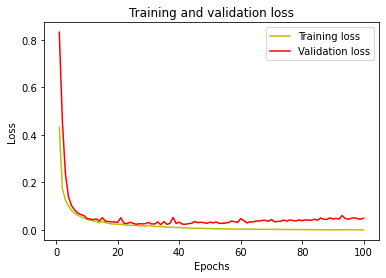

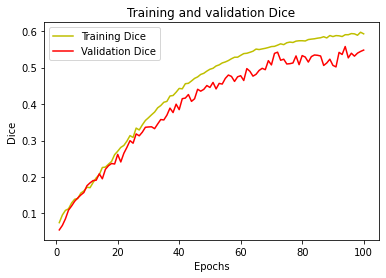

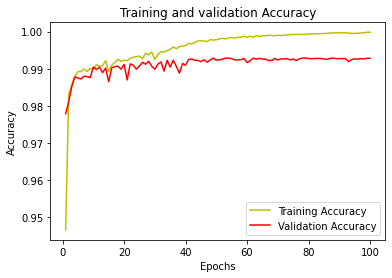

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['dice_coefficient']
val_acc = history.history['val_dice_coefficient']

plt.plot(epochs, acc, 'y', label='Training Dice')
plt.plot(epochs, val_acc, 'r', label='Validation Dice')
plt.title('Training and validation Dice')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
len(x_valid)

17

1/1 [==============================] - 0s 190ms/step - loss: 0.0500 - jacard_coef: 0.0376 - dice_coefficient: 0.3834 - accuracy: 0.9928


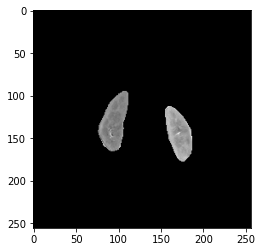

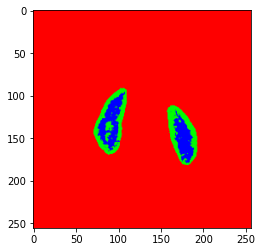

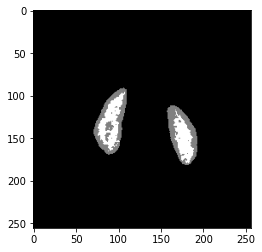

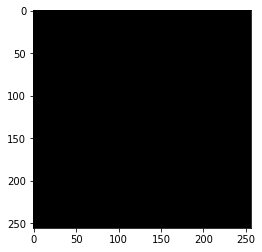

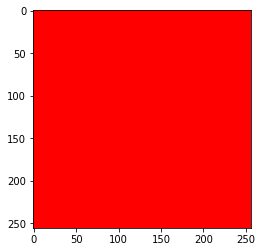

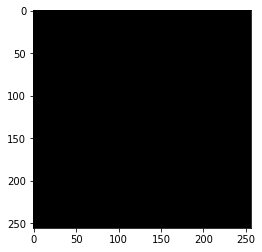

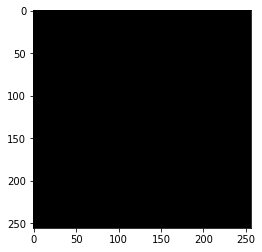

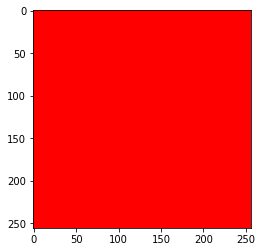

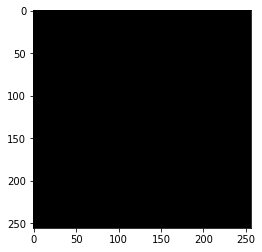

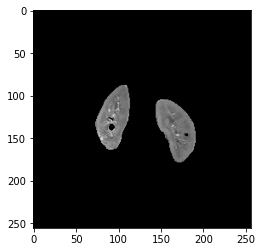

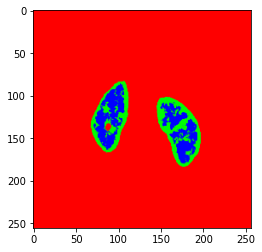

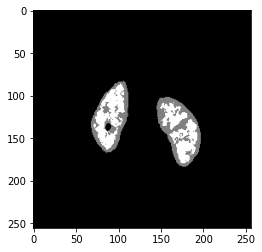

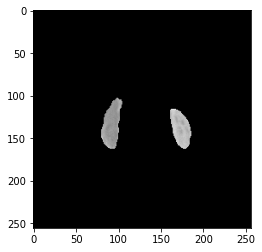

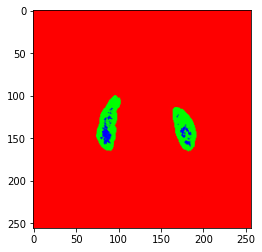

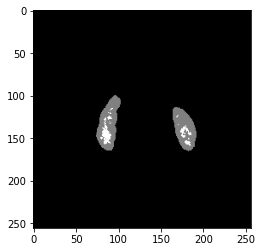

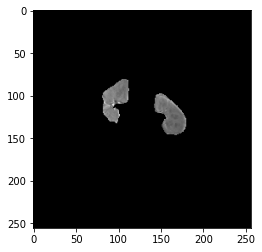

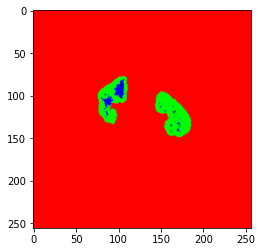

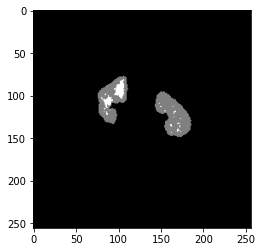

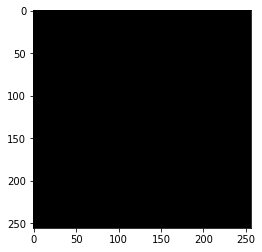

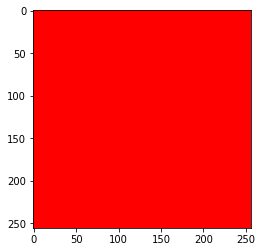

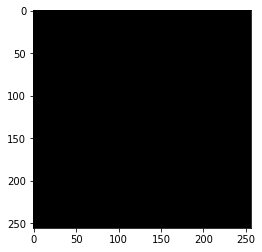

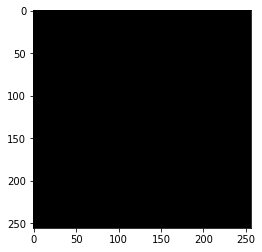

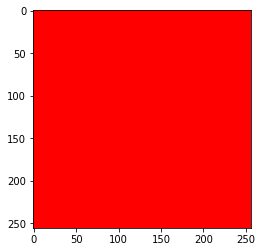

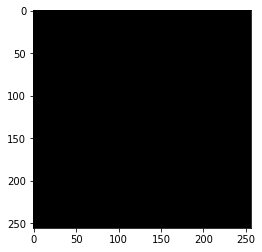

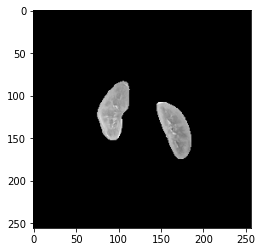

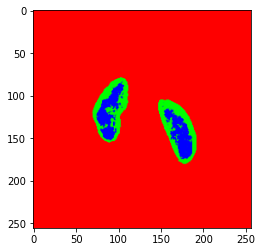

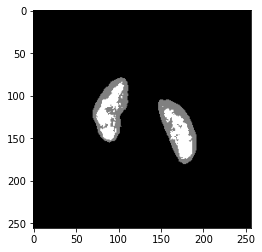

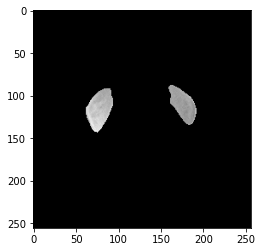

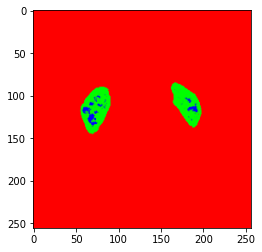

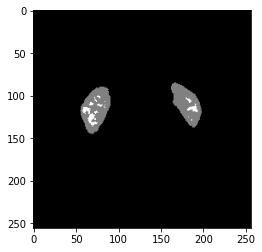

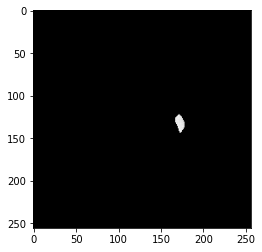

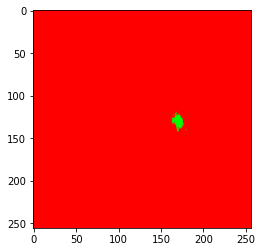

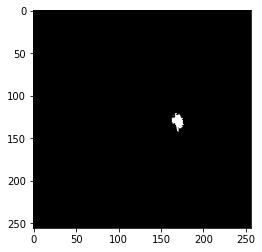

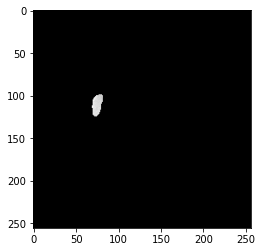

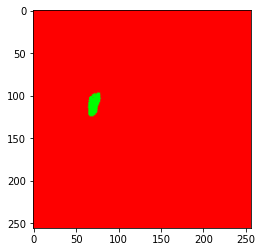

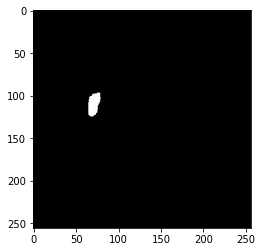

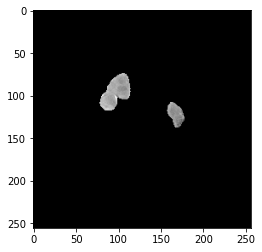

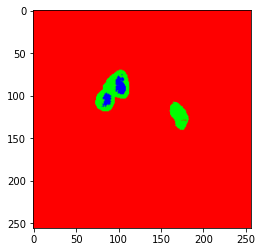

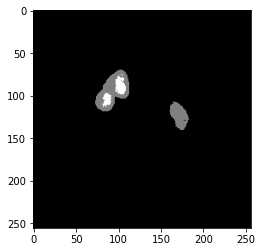

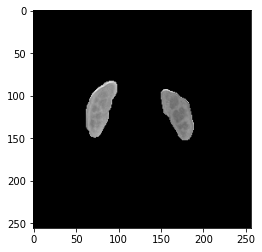

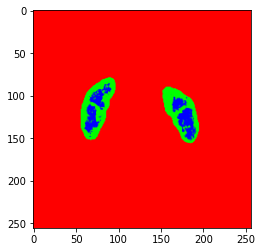

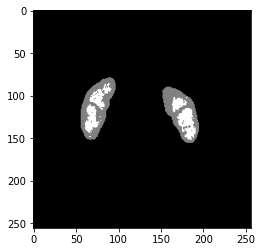

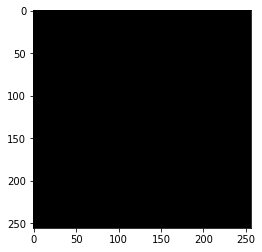

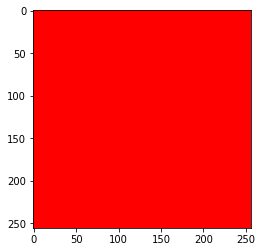

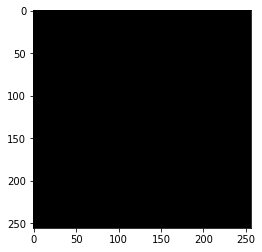

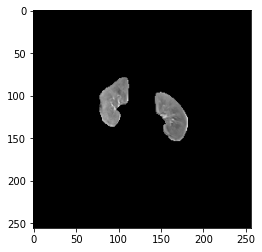

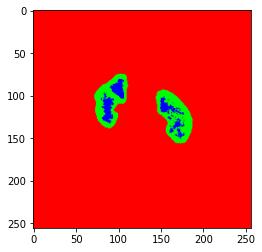

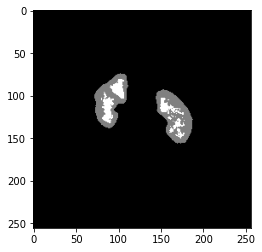

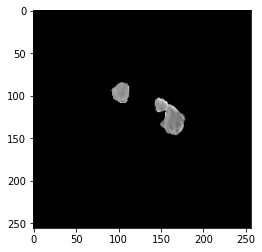

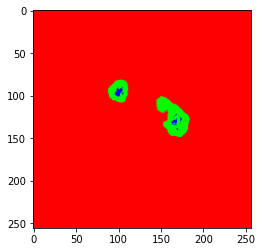

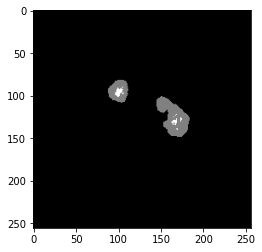

In [ ]:
model.evaluate(x_valid, y_valid)
predicted_masks = model.predict(x_valid)
plt.show()
for i in range(0,len(x_valid)):
  plt.imshow(ndi.rotate(np.squeeze(x_valid[i]),-90), cmap='gray')
  plt.show()
  # plt.imshow(np.squeeze(y_train[i]))
  # plt.show()
  plt.imshow(ndi.rotate(np.squeeze(predicted_masks[i]),-90), cmap='gray')
  plt.show()


  def display_mask(j):
      """Quick utility to display a model's prediction."""
      mask = np.argmax(predicted_masks[i], axis=-1)
      mask = np.expand_dims(mask, axis=-1)
      img = ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
      #display(img)
      plt.imshow(ndi.rotate(np.squeeze(mask),-90), cmap='gray')
      plt.show()


  display_mask(predicted_masks[i])

